In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.abspath('../'))
sys.path.insert(1, os.path.abspath('../../..'))

from modules.plots import set_aspect
from modules.utils import save_descriptive_stats,save_variables, significance_asterisk
from modules.config import data_reports_path, figpath, pre_color, post_color, default_color

In [3]:
# Load the quantitative metrics of messaging balance (see preprocessing for the calculation)
analysis = 'speed'
data = pd.read_excel(Path('../../data/processed/absolute_speed_data.xlsx'))
bin_columns = ['speed-<1min','speed-1-2min','speed-3-5min','speed-6-15min','speed-16-30min','speed-31-60min','speed->60min']
bin_labels  = [col.replace('speed-', '') for col in bin_columns]

### Fig. A9A - Plot the selection of each bin in the pre- and post-assessments. 

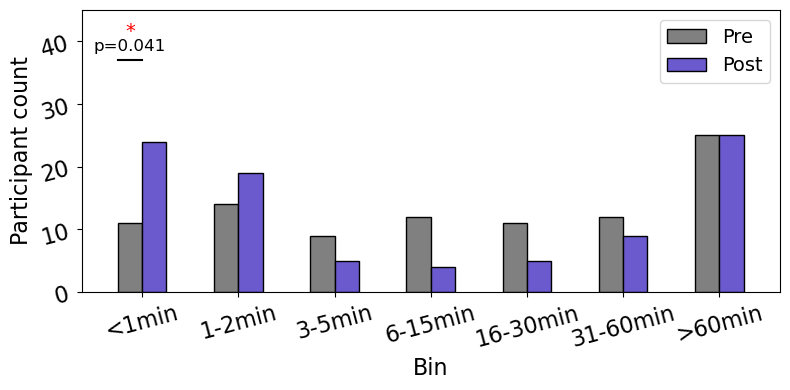

In [8]:
from modules.plots import plot_bin_selection
plot_bin_selection(data,bin_columns,analysis,name='survey')
save_variables(data_reports_path,f'{analysis}-N',len(data))

### Fig. 5A - Plot the selected bins in order of their objective rankings.

Rankings are based on the probability of sending messages in that bin for each participant. Use the McNemar test to statistically compare the selection before and after the feedback.

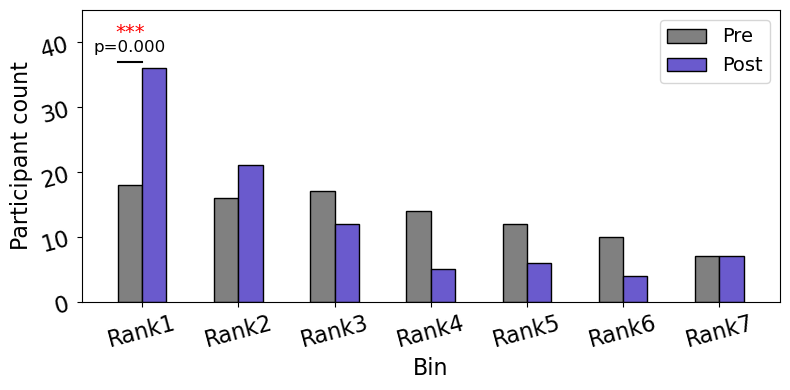

In [9]:
# Initialize lists to store binary responses by objective bin rank
# Sort by ranks (1= highest probability bin, etc.)

objective_bins_pre = {f'Rank{i}': [] for i in range(1, len(bin_columns)+1)}
objective_bins_post = {f'Rank{i}': [] for i in range(1, len(bin_columns)+1)}

# Iterate over each participant's data
for index, row in data.iterrows():
    # Get the model's writing probabilities for each bin for this participant
    speed_p = row[bin_columns]
    
    # Sort bins by writing probability in descending order
    sorted_series = speed_p.sort_values(ascending=False)
    sorted_columns = sorted_series.index.tolist()
    
    # Assign pre/post responses to bins ranked by objective model probability
    for ind, col in enumerate(sorted_columns):
        objective_bins_pre[f'Rank{ind+1}'].append(row[f'{col}_pre'])
        objective_bins_post[f'Rank{ind+1}'].append(row[f'{col}_post'])

# Convert dictionaries to DataFrames
df_pre = pd.DataFrame(objective_bins_pre)
df_post = pd.DataFrame(objective_bins_post)

# Rename columns to indicate pre/post
df_pre.columns = [f'{col}_pre' for col in df_pre.columns]
df_post.columns = [f'{col}_post' for col in df_post.columns]

# Concatenate along columns
ranks_df = pd.concat([df_pre, df_post], axis=1)
ranks = ['Rank1', 'Rank2', 'Rank3', 'Rank4', 'Rank5',
       'Rank6', 'Rank7']

plot_bin_selection(ranks_df,ranks,analysis,name='obj')

### Fig. A9B - Plot the overall probability of responding within a certain bin for the entire sample. 

The shaded areas are the standard deviations. 

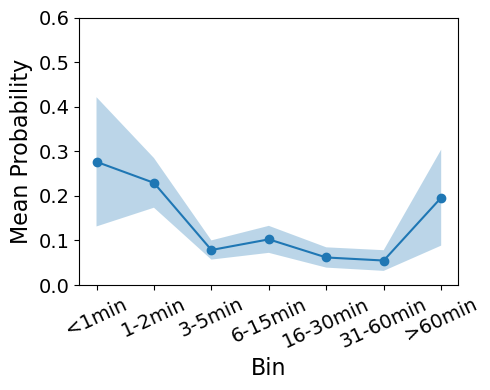

In [7]:
# Compute mean and standard deviation for each bin
means = data[bin_columns].mean(axis=0)
std = data[bin_columns].std(axis=0)
x = range(len(bin_labels))

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the means and shaded areas
ax.plot(x, means, 'o-', label='Mean probability')
ax.fill_between(x, means - std, means + std, alpha=0.3)

# Axis labels and ticks
ax.set_ylabel('Mean Probability', fontsize=16)
ax.set_xlabel('Bin', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=25)
ax.set_ylim(0, 0.6)
ax.tick_params(axis='both', labelsize=14)

# Final layout and save
fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig(Path(f'{figpath}/{analysis}-bin-obj-prob.png'))
fig.savefig(Path(f'{figpath}/{analysis}-bin-obj-prob.svg'))